In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Word Cloud
from wordcloud import WordCloud
# from textacy import preprocessing
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [ ]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/IA3-PROYECTO/datos.csv')
df.head()
# Rename Columns
df.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)
# Dropping the Index Colums
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()
# significado de los numeros:
# 0 = sadness
# 1 = joy
# 2 = love
# 3 = anger
# 4 = fear
# 5 = surprise

,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
import re
# si prefieres unicode amplio, pip install regex y usar regex module
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # quitar URLs
    text = re.sub(r'http\S+|www\.\S+|https\S+', '', text, flags=re.MULTILINE)
    # quitar menciones y hashtags (pero podrías conservar el token 'hashtag' si quieres)
    text = re.sub(r'@\w+|#\w+', '', text)
    # eliminar caracteres que no sean letras (incluyendo acentos) ni espacios
    text = re.sub(r'[^A-Za-zÁÉÍÓÚáéíóúÜüÑñ\s]', '', text)
    # quitar espacios extras
    text = re.sub(r'\s+', ' ', text).strip()
    return text



/tmp/ipython-input-3778936138.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


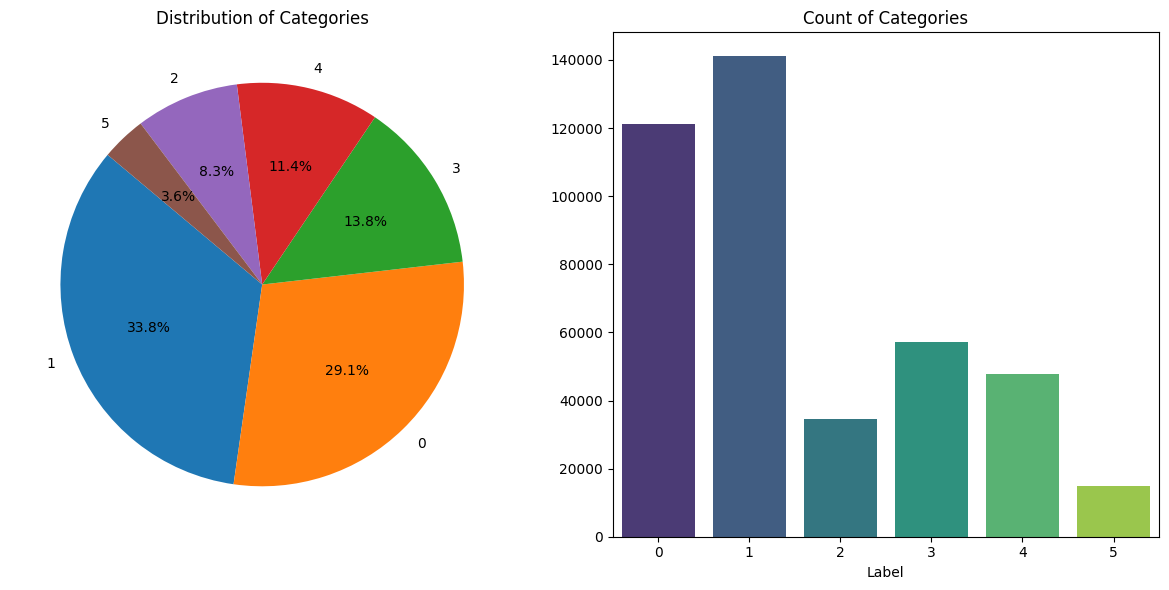

In [ ]:
# Value Count Of Label
count = df['Label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

MIRANDO BALANCEO DE CLASES

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("=== MÉTODO A: SOLO CLASS_WEIGHT ===")

# class_weight calculado sobre la distribución ORIGINAL
class_weights_A_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['Label']),
    y=df['Label']
)
class_weights_A = dict(enumerate(class_weights_A_arr))

print("Pesos de clase A:", class_weights_A)

# Dataset final para este experimento
df_A = df.copy()


=== MÉTODO A: SOLO CLASS_WEIGHT ===
Pesos de clase A: {0: np.float64(0.5732311771614668), 1: np.float64(0.492448032967786), 2: np.float64(2.010423298798017), 3: np.float64(1.2119993486516507), 4: np.float64(1.4559894086742677), 5: np.float64(4.63987220589545)}


In [ ]:
from sklearn.utils import resample

print("=== MÉTODO B: SOLO OVERSAMPLING ===")

counts = df['Label'].value_counts().sort_index()
target_size = int(counts.median())  # oversampling moderado

balanced_subsets = []

for label, cnt in counts.items():
    subset = df[df['Label'] == label]
    if cnt < target_size:
        subset_resampled = resample(subset, replace=True,
                                    n_samples=target_size,
                                    random_state=42)
    else:
        subset_resampled = subset
    balanced_subsets.append(subset_resampled)

df_B = pd.concat(balanced_subsets).sample(frac=1, random_state=42)

print("Clases tras oversampling B:")
print(df_B['Label'].value_counts())


=== MÉTODO B: SOLO OVERSAMPLING ===
Clases tras oversampling B:
Label
1    141067
0    121187
3     57317
2     52514
5     52514
4     52514
Name: count, dtype: int64


In [ ]:
print("=== MÉTODO C: OVERSAMPLING + CLASS_WEIGHT ORIGINAL ===")

# Reutilizamos oversampling de B
df_C = df_B.copy()

# class_weight calculado desde el dataset original
class_weights_C_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['Label']),
    y=df['Label']
)
class_weights_C = dict(enumerate(class_weights_C_arr))

print("Pesos de clase C (ORGINALES):", class_weights_C)


=== MÉTODO C: OVERSAMPLING + CLASS_WEIGHT ORIGINAL ===
Pesos de clase C (ORGINALES): {0: np.float64(0.5732311771614668), 1: np.float64(0.492448032967786), 2: np.float64(2.010423298798017), 3: np.float64(1.2119993486516507), 4: np.float64(1.4559894086742677), 5: np.float64(4.63987220589545)}


PREPORCESAMIENTO

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Apply clean_text function to create a new 'clean_text' column
df['clean_text'] = df['Text'].apply(clean_text)
df_A['clean_text'] = df_A['Text'].apply(clean_text)
df_B['clean_text'] = df_B['Text'].apply(clean_text)
df_C['clean_text'] = df_C['Text'].apply(clean_text)

# Usamos el mismo tokenizer para los 3
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text']) # Changed from 'text' to 'clean_text'
max_len = 30

def prepare_data(df_input):
    X_seq = tokenizer.texts_to_sequences(df_input['clean_text'])
    X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')
    y_cat = to_categorical(df_input['Label'], num_classes=6)
    return train_test_split(X_pad, y_cat, test_size=0.2, random_state=42, stratify=df_input['Label'])

X_A_train, X_A_val, y_A_train, y_A_val = prepare_data(df_A)
X_B_train, X_B_val, y_B_train, y_B_val = prepare_data(df_B)
X_C_train, X_C_val, y_C_train, y_C_val = prepare_data(df_C)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras

@keras.saving.register_keras_serializable()
class AttentionLayer(layers.Layer):
    def __init__(self, units=None, **kwargs):
        super().__init__(**kwargs)

        # Si units no vino en el config, poner valor por defecto
        self.units = units if units is not None else 32

        self.W = layers.Dense(self.units)
        self.U = layers.Dense(self.units)
        self.v = layers.Dense(1)

    def call(self, inputs, mask=None):
        keys, values = inputs

        score = self.v(tf.nn.tanh(self.W(keys) + self.U(values)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context = attention_weights * values
        context = tf.reduce_sum(context, axis=1)

        return context, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Si 'units' no está, poner un valor por defecto
        config["units"] = config.get("units", 32)
        return cls(**config)


MODELO

In [ ]:
def build_model(vocab_size=5000, embedding_dim=64,
                gru_units=32, att_units=32, max_len=30):

    inputs = layers.Input(shape=(max_len,), name="input_ids")

    # === Embedding propio (random trainable) ===
    x = layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_len,trainable=True,name="embedding")(inputs)

    # === CNN ligera (detecta negación y patrones como "no es bueno") ===
    x = layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding="same",
        activation="relu"
    )(x)

    x = layers.MaxPooling1D(pool_size=2)(x)

    # === BiGRU ligera (sin recurrent_dropout → GPU rápido) ===
    x = layers.Bidirectional(
        layers.GRU(gru_units, return_sequences=True,
                   dropout=0.2, recurrent_dropout=0),
        name="bigru"
    )(x)

    # === Atención personalizada ===
    attention_layer = AttentionLayer(att_units, name="custom_attention")
    context_vector, attention_scores = attention_layer([x, x])

    # Normalización
    context_vector = layers.LayerNormalization()(context_vector)

    # === Capa densa ===
    dense = layers.Dense(64, activation="relu")(context_vector)
    dense = layers.Dropout(0.3)(dense)

    # === Clasificación ===
    outputs = layers.Dense(6, activation='softmax', name="classifier")(dense)

    # Modelos finales
    model = Model(inputs=inputs, outputs=outputs, name="OptimizedEmotionClassifier")
    attention_extractor = Model(inputs=inputs, outputs=attention_scores)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, attention_extractor


ENTRENANDO 3 modelos

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/IA3-PROYECTO/modelos_entrenados"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_models(name, model, attention_extractor):
    model.save(f"{SAVE_DIR}/{name}.keras")
    attention_extractor.save(f"{SAVE_DIR}/{name}_attention.keras")
    print(f"💾 Modelos guardados en carpeta → {SAVE_DIR}")


In [ ]:
class TimeHistory(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        print(f"⏳ Tiempo en Epoch {epoch+1}: {elapsed:.2f} segundos")


In [ ]:
results = {}

def train_model(name, X_train, y_train, X_val, y_val, class_weights=None):
    print(f"\n🔷 Entrenando {name} ...")

    model, attention_extractor = build_model()

    checkpoint = ModelCheckpoint(
        f"{SAVE_DIR}/{name}_best.keras",
        save_best_only=True,
        monitor="val_accuracy",
        verbose=1
    )

    early = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    time_callback = TimeHistory()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,        # suficiente con este modelo
        batch_size=64,    # más rápido en GPU
        callbacks=[checkpoint, early, time_callback],
        class_weight=class_weights,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    save_models(name, model, attention_extractor)

    results[name] = {
        "accuracy": val_acc,
        "loss": val_loss,
        "history": history,
        "model": model,
        "attention_extractor": attention_extractor
    }

    return model, attention_extractor, history


In [ ]:
model_A, attention_A, history_A = train_model(
    "model_A",
    X_A_train, y_A_train,
    X_A_val, y_A_val,
    class_weights=class_weights_A
)

model_B, attention_B, history_B = train_model(
    "model_B",
    X_B_train, y_B_train,
    X_B_val, y_B_val,
    class_weights=None
)

model_C, attention_C, history_C = train_model(
    "model_C",
    X_C_train, y_C_train,
    X_C_val, y_C_val,
    class_weights=class_weights_C
)



🔷 Entrenando model_A ...
Epoch 1/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7935 - loss: 0.5183
Epoch 1: val_accuracy improved from -inf to 0.91101, saving model to /content/drive/MyDrive/IA3-PROYECTO/modelos_entrenados/model_A_best.keras
⏳ Tiempo en Epoch 1: 86.99 segundos
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - accuracy: 0.7935 - loss: 0.5182 - val_accuracy: 0.9110 - val_loss: 0.2012
Epoch 2/10
5210/5211 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9090 - loss: 0.1982
Epoch 2: val_accuracy did not improve from 0.91101
⏳ Tiempo en Epoch 2: 72.79 segundos
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.9090 - loss: 0.1982 - val_accuracy: 0.9103 - val_loss: 0.2018
Epoch 3/10
5210/5211 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9114 - loss: 0.1860
Epoch 3: val_accuracy improved from 0.91101 to 0.91313, saving model to /content/drive/MyDrive/IA3-PROYECTO/modelos_entrenados/model_A_best.keras
⏳ Tiempo en Epoch 3: 72.68 segundos
5211/5211 ━━━━━━━

In [ ]:
# ============================================
# ========== 1. FUNCIONES DE EVALUACIÓN =======
# ============================================

from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_f1_macro(model, X_val, y_val):
    y_pred = model.predict(X_val).argmax(axis=1)
    y_true = y_val.argmax(axis=1)
    return f1_score(y_true, y_pred, average='macro')


def plot_confusion(model, X_val, y_val, title):
    y_pred = model.predict(X_val).argmax(axis=1)
    y_true = y_val.argmax(axis=1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

In [ ]:
# ============================================
# ========== 2. MÉTRICAS DE LOS MODELOS =======
# ============================================

f1_A = calculate_f1_macro(model_A, X_A_val, y_A_val)
f1_B = calculate_f1_macro(model_B, X_B_val, y_B_val)
f1_C = calculate_f1_macro(model_C, X_C_val, y_C_val)

print("F1 Macro Modelo A:", f1_A)
print("F1 Macro Modelo B:", f1_B)
print("F1 Macro Modelo C:", f1_C)


print("\n📌 Classification Report — Modelo A")
print(classification_report(
    y_A_val.argmax(axis=1),
    model_A.predict(X_A_val).argmax(axis=1)
))

print("\n📌 Classification Report — Modelo B")
print(classification_report(
    y_B_val.argmax(axis=1),
    model_B.predict(X_B_val).argmax(axis=1)
))

print("\n📌 Classification Report — Modelo C")
print(classification_report(
    y_C_val.argmax(axis=1),
    model_C.predict(X_C_val).argmax(axis=1)
))

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
F1 Macro Modelo A: 0.8870496273586435
F1 Macro Modelo B: 0.9199389188777797
F1 Macro Modelo C: 0.917066242839424

📌 Classification Report — Modelo A
2606/2606 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     24238
           1       0.98      0.89      0.94     28214
           2       0.70      0.98      0.82      6911
           3       0.90      0.93      0.91     11463
           4       0.89      0.87      0.88      9542
           5       0.71      0.97      0.82      2994

    accuracy                           0.92     83362
   macro avg       0.86      0.93      0.89     83362
weighted avg       0.93      0.92      0.92     83362


📌 Classification Report — Modelo B
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
              precision    recall  f1-score   support

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


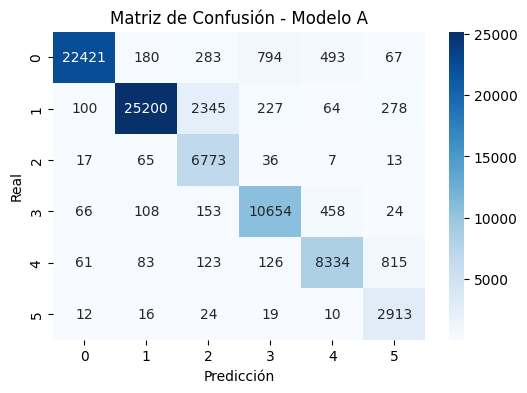

2982/2982 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


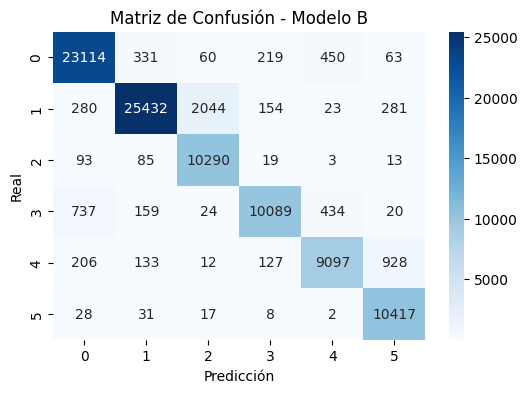

2982/2982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


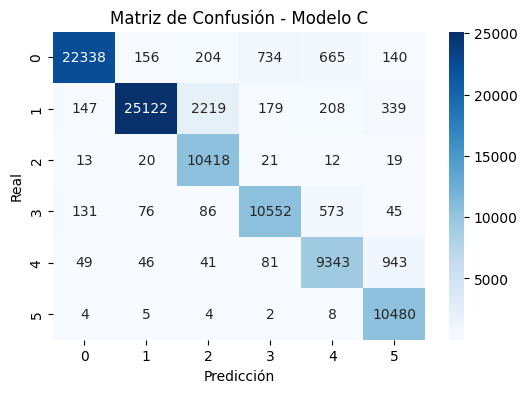

In [ ]:
# ============================================
# ======== 3. MATRICES DE CONFUSIÓN ===========
# ============================================

plot_confusion(model_A, X_A_val, y_A_val, "Matriz de Confusión - Modelo A")
plot_confusion(model_B, X_B_val, y_B_val, "Matriz de Confusión - Modelo B")
plot_confusion(model_C, X_C_val, y_C_val, "Matriz de Confusión - Modelo C")

In [ ]:
# ============================================
# ======== 4. TABLA COMPARATIVA FINAL =========
# ============================================

df_eval = pd.DataFrame({
    "Modelo": ["A_class_weight", "B_oversampling", "C_over+weight"],
    "Accuracy": [
        results["model_A"]["accuracy"],
        results["model_B"]["accuracy"],
        results["model_C"]["accuracy"]
    ],
    "Loss": [
        results["model_A"]["loss"],
        results["model_B"]["loss"],
        results["model_C"]["loss"]
    ],
    "F1 Macro": [f1_A, f1_B, f1_C]
})

print("\n📊 TABLA COMPARATIVA FINAL:")
display(df_eval)

best_index = df_eval["F1 Macro"].idxmax()
best_model_name = df_eval.loc[best_index, "Modelo"]
best_f1 = df_eval.loc[best_index, "F1 Macro"]

print(f"\n🏆 Mejor modelo según F1 Macro: {best_model_name}")
print(f"🔍 F1 Macro obtenido: {best_f1:.4f}")

# Asignación del modelo ganador
if best_model_name == "A_class_weight":
    best_model = model_A
    X_val_best = X_A_val
    y_val_best = y_A_val
elif best_model_name == "B_oversampling":
    best_model = model_B
    X_val_best = X_B_val
    y_val_best = y_B_val
else:
    best_model = model_C
    X_val_best = X_C_val
    y_val_best = y_C_val

print("\n📌 Modelo final listo para inferencias como 'best_model'")



📊 TABLA COMPARATIVA FINAL:


,Modelo,Accuracy,Loss,F1 Macro
0,A_class_weight,0.915225,0.176165,0.887050
1,B_oversampling,0.926810,0.160691,0.919939
2,C_over+weight,0.924861,0.188599,0.917066



🏆 Mejor modelo según F1 Macro: B_oversampling
🔍 F1 Macro obtenido: 0.9199

📌 Modelo final listo para inferencias como 'best_model'


In [ ]:
# ============================================
# ========== 5. PREDICCIÓN DE EMOCIONES =======
# ============================================

emotion_dict = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

def clean_text_input(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^A-Za-zÁÉÍÓÚÜÑáéíóúüñ\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def prepare_input(sentence):
    cleaned = clean_text_input(sentence)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    return pad_seq


def predict_emotion(sentence, model=best_model):
    x_input = prepare_input(sentence)
    pred = model.predict(x_input)[0]

    emotion_id = pred.argmax()
    emotion_label = emotion_dict[emotion_id]

    print(f"\n📝 Texto ingresado:\n{sentence}")
    print(f"\n🎯 Emoción predicha: **{emotion_label.upper()}**\n")

    print("📊 Probabilidades por emoción:")
    for idx, prob in enumerate(pred):
        print(f"  {emotion_dict[idx]:10s}: {prob:.4f}")

    return emotion_label, pred

In [ ]:
def get_attention_weights(sentence, extractor_model):
    x_input = prepare_input(sentence)
    att_scores = extractor_model.predict(x_input)[0]
    return att_scores.squeeze(-1)


In [ ]:
def plot_attention(sentence, extractor_model):
    cleaned = clean_text_input(sentence)
    words = cleaned.split()

    attention = get_attention_weights(sentence, extractor_model)
    attention = attention[:len(words)]

    plt.figure(figsize=(12, 1.5))
    plt.imshow([attention], cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(len(words)), words, rotation=45)
    plt.yticks([])
    plt.title("Mapa de Atención — Importancia por palabra")
    plt.show()


In [ ]:
# ============================================
#   SELECCIÓN DEL EXTRACTOR CORRECTO
# ============================================

# Ya tienes best_model_name y best_model desde tu tabla comparativa
# Ahora elegimos el extractor correspondiente.

if best_model_name == "A_class_weight":
    best_attention = attention_A
elif best_model_name == "B_oversampling":
    best_attention = attention_B
else:
    best_attention = attention_C

print(f"Extractor asignado: {best_attention.name}")


Extractor asignado: functional_9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step

📝 Texto ingresado:
Familiarity with the environment sparked a new interest: I started feeling more curious about the people once I understood the lay of the land.

🎯 Emoción predicha: **SURPRISE**

📊 Probabilidades por emoción:
  sadness   : 0.0000
  joy       : 0.0000
  love      : 0.0000
  anger     : 0.0000
  fear      : 0.0000
  surprise  : 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


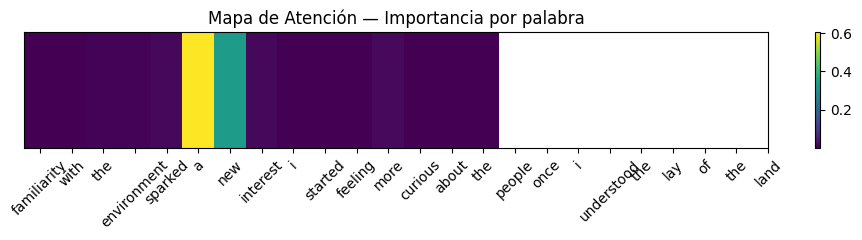

In [ ]:
# Texto de prueba
text = "Familiarity with the environment sparked a new interest: I started feeling more curious about the people once I understood the lay of the land."

# Predicción (usa best_model automáticamente)
predict_emotion(text, best_model)

# Gráfica de atención (usa el extractor correcto)
plot_attention(text, best_attention)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/IA3-PROYECTO/modelos_entrenados/model_B_best.keras"
ATTENTION_PATH = "/content/drive/MyDrive/IA3-PROYECTO/modelos_entrenados/model_B_attention.keras"

best_model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={"AttentionLayer": AttentionLayer}
)

best_attention = tf.keras.models.load_model(
    ATTENTION_PATH,
    custom_objects={"AttentionLayer": AttentionLayer}
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'custom_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

📝 Texto ingresado:
I am proud of how far I have come, even if the road was exhausting

🎯 Emoción predicha: **JOY**

📊 Probabilidades por emoción:
  sadness   : 0.0241
  joy       : 0.5310
  love      : 0.0000
  anger     : 0.0044
  fear      : 0.4405
  surprise  : 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


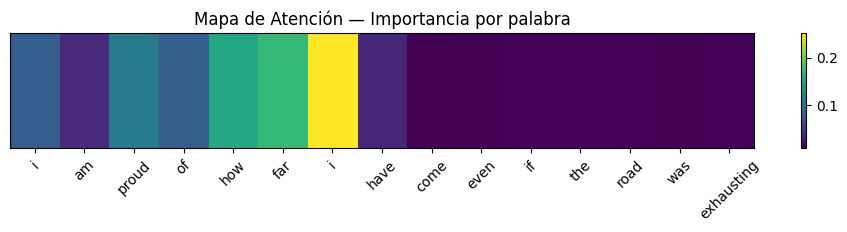

In [ ]:
# Texto de prueba
text = "I am proud of how far I have come, even if the road was exhausting"

# Predicción (usa best_model automáticamente)
predict_emotion(text, best_model)

# Gráfica de atención (usa el extractor correcto)
plot_attention(text, best_attention)